In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
features = pd.read_csv('temps.csv')
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2019,1,1,Fri,45,45,45.6,45,29
1,2019,1,2,Sat,44,45,45.7,44,61
2,2019,1,3,Sun,45,44,45.8,41,56
3,2019,1,4,Mon,44,41,45.9,40,53
4,2019,1,5,Tues,41,40,46.0,44,41


year, month,day,week for time
temp_2: Max Temp of the day before yesterday 
temp_1: Max Temp of yesterday 
average: average Max Temp in history
actual: our label data, real Max Temp for that day
friend: could be the guess number from your friends

In [3]:
print("shape: ",features.shape)

shape:  (348, 9)


348 rows by 9 columns

In [4]:
import datetime

years = features['year']
months = features['month']
days = features['day']

#generate datetime format
dates=[str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]
dates[0:5]

[datetime.datetime(2019, 1, 1, 0, 0),
 datetime.datetime(2019, 1, 2, 0, 0),
 datetime.datetime(2019, 1, 3, 0, 0),
 datetime.datetime(2019, 1, 4, 0, 0),
 datetime.datetime(2019, 1, 5, 0, 0)]

Text(0.5, 1.0, 'Friend Estimate')

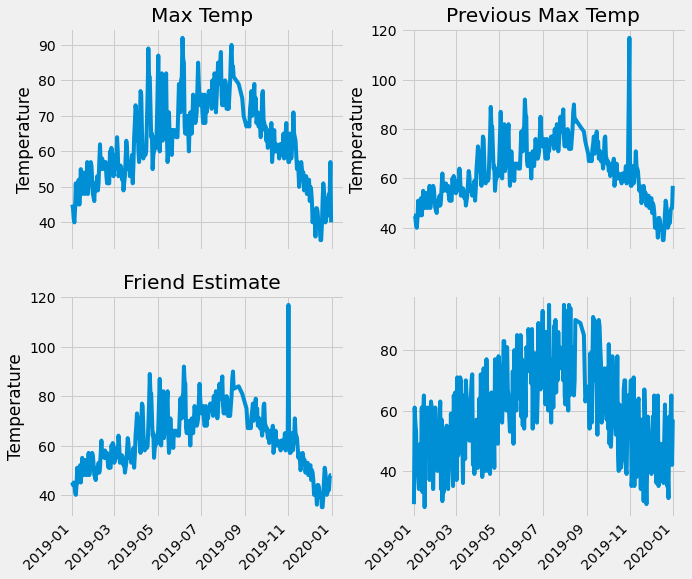

In [5]:
#prepare for plotting current data
plt.style.use('fivethirtyeight')
#layout
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.autofmt_xdate(rotation=45)

#Actual
ax1.plot(dates,features['actual'])
ax1.set_xlabel('');ax1.set_ylabel('Temperature');ax1.set_title('Max Temp')

#Yesterday
ax2.plot(dates,features['temp_1'])
ax2.set_xlabel('');ax2.set_ylabel('Temperature');ax2.set_title('Previous Max Temp')

#two days ago
ax3.plot(dates,features['temp_2'])
ax3.set_xlabel('');ax3.set_ylabel('Temperature');ax3.set_title('Two Days Prior Max Temp')

#Friends
ax4.plot(dates,features['friend'])
ax4.set_xlabel('');ax3.set_ylabel('Temperature');ax3.set_title('Friend Estimate')


In [6]:
#normallize week data due to its string
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2019,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2019,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2019,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2019,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2019,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


week column is converted to 7 columns

In [7]:
#the result will come out quicker after normallized the data
#define the labels
labels=np.array(features['actual'])

#remove labels in features dataset
features = features.drop('actual',axis=1)

#keep the names seperately
feature_list = list(features.columns)

#convert to np format
features = np.array(features)

#pre-process the data with standard scaler process
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [8]:
input_features

array([[ 0.        , -1.5678393 , -1.65682171, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.54267126, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.4285208 , ..., -0.40482045,
        -0.41913682, -0.40482045],
       ...,
       [ 0.        ,  1.5810006 ,  1.53939107, ...,  2.47023092,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.65354153, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.76769198, ..., -0.40482045,
        -0.41913682, -0.40482045]])

In [9]:
#Create Grid model
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16

my_nn = torch.nn.Sequential(torch.nn.Linear(input_size,hidden_size), torch.nn.Sigmoid(), torch.nn.Linear(hidden_size,output_size))
cost = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

#train the network
losses=[]
for i in range(1000):
    batch_loss=[]
    #train with MINI-batch
    for start in range(0,len(input_features),batch_size):
        end = start + batch_size if start+batch_size<len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end],dtype=torch.float,requires_grad=True)
        yy = torch.tensor(labels[start:end],dtype=torch.float,requires_grad=True)
        prediction = my_nn(xx)
        loss = cost (prediction,yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
        
    if i%100==0:
        losses.append(np.mean(batch_loss))
        print(i,np.mean(batch_loss))

0 3909.1406
100 37.987816
200 35.640305
300 35.311634
400 35.12634
500 34.97553
600 34.842747
700 34.71508
800 34.586212
900 34.453266


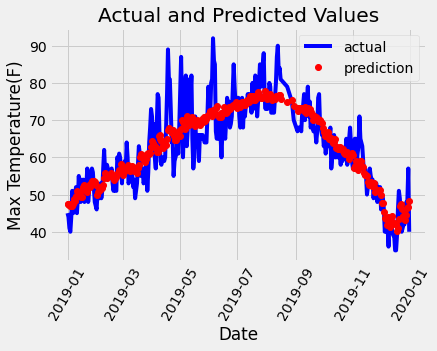

In [32]:
#Result from pre-trained
x = torch.tensor(input_features,dtype=torch.float)
predict=my_nn(x).data.numpy()

#change the date format
dates=[str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

#create a table to keep date and labels
true_data = pd.DataFrame(data={'date':dates,'actual':labels})

#create a table to keep date and predict values
months = features[:,feature_list.index('month')]
days = features[:,feature_list.index('day')]
years = features[:,feature_list.index('year')]

test_dates=[str(int(year))+'-'+str(int(month))+'-'+str(int(day)) for year,month,day in zip(years,months,days)]
test_dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in test_dates]
predictions_data = pd.DataFrame(data={'date':test_dates, 'prediction':predict.reshape(-1)})

#plot true value
plt.plot(true_data['date'],true_data['actual'],'b-',label='actual')

#plot Predicted values
plt.plot(predictions_data['date'],predictions_data['prediction'],'ro',label='prediction')
plt.xticks(rotation='60')
plt.legend()

#plot labels, titles
plt.xlabel('Date');plt.ylabel('Max Temperature(F)');plt.title('Actual and Predicted Values');